In [1]:
import sys
print(sys.version)

3.9.12 (main, Jun  1 2022, 11:38:51) 
[GCC 7.5.0]


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.2


In [4]:
path = 'vw_3_golf.csv'
column_names = ['Year', 'Price', 'Transmission', 'Mileage',
                'FuelType', 'Tax', 'EngineSize']

raw_dataset = pd.read_csv(path, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [6]:
dataset = raw_dataset.copy()

In [7]:
dataset = dataset.dropna()

In [8]:
dataset = pd.get_dummies(dataset, columns=['Transmission', 'FuelType'], prefix='', prefix_sep='')

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

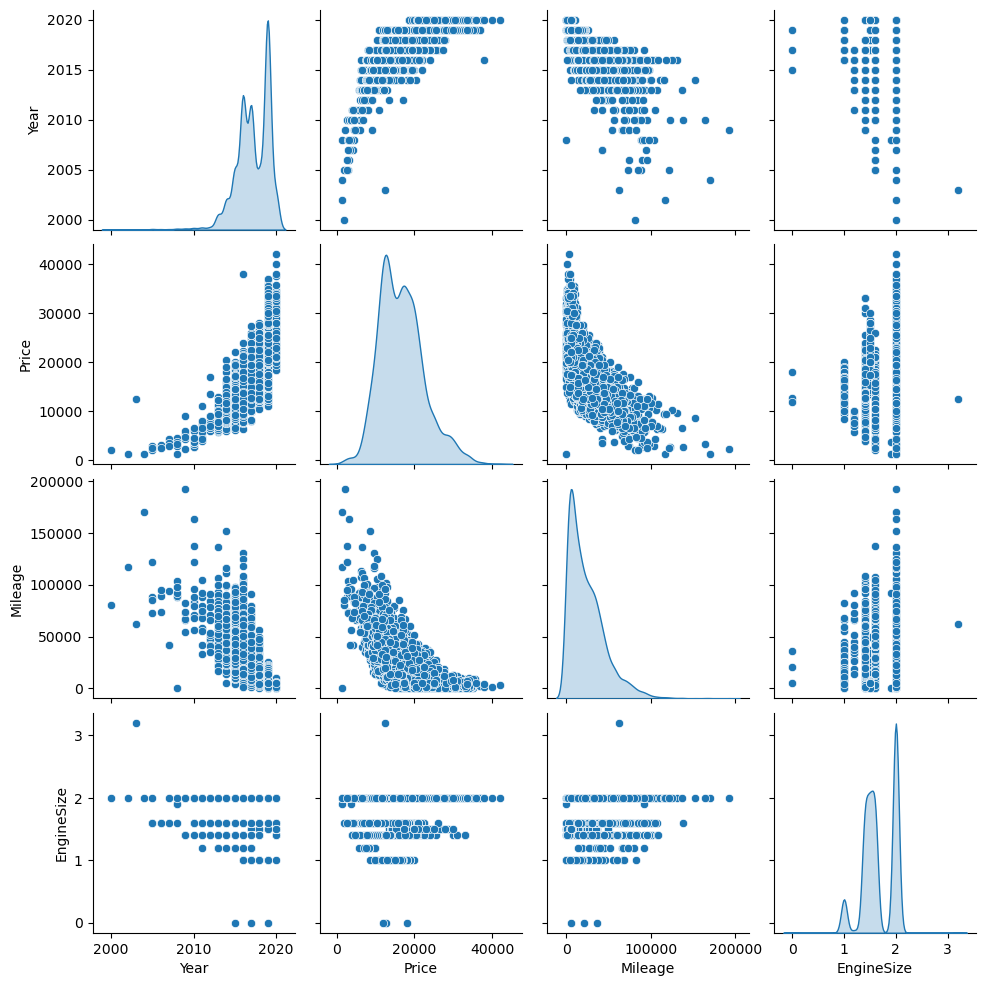

In [11]:
sns.pairplot(train_dataset[['Year', 'Price', 'Mileage', 'EngineSize']], diag_kind='kde')

In [12]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Price')
test_labels = test_features.pop('Price')

In [13]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [14]:
normalizer.adapt(np.array(train_features))

2022-08-28 20:55:36.659425: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-28 20:55:36.664411: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
print(normalizer.mean.numpy())

[[ 2017.166 24007.33    101.224     1.659     0.124     0.597     0.279
      0.414     0.017     0.006     0.562]]


In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 4000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Price]')
  plt.legend()
  plt.grid(True)

In [17]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [18]:
test_results = {}

In [19]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 11)               23        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,016
Trainable params: 4,993
Non-trainable params: 23
_________________________________________________________________


In [20]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 6min 43s, sys: 6min 27s, total: 13min 11s
Wall time: 1min 7s


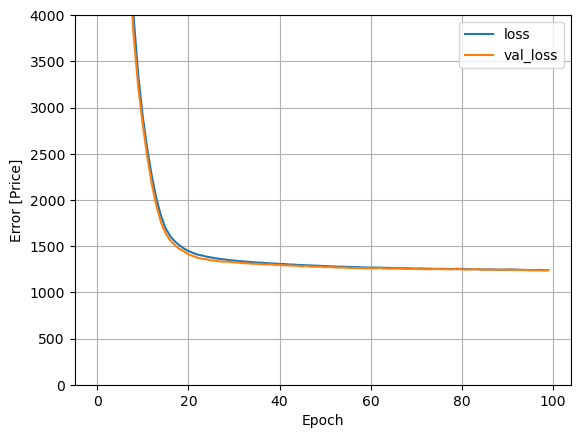

In [21]:
plot_loss(history)

In [22]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

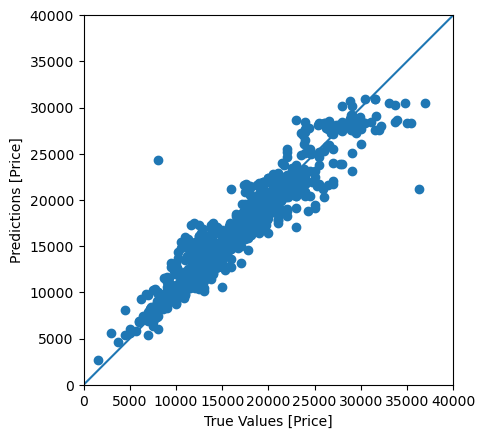

In [24]:
test_predictions = dnn_model.predict(test_features).flatten()


a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
lims = [0, 40000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

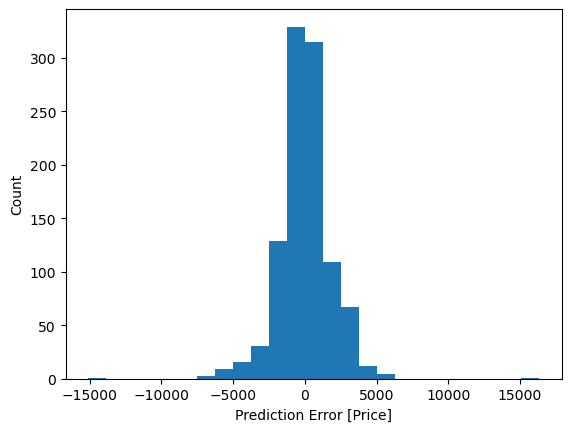

In [25]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Price]')
_ = plt.ylabel('Count')